In [98]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import pandas as pd
import os
from io import StringIO  


from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import matthews_corrcoef, confusion_matrix, accuracy_score,plot_confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.model_selection import GridSearchCV

from IPython.display import Image

# benötigt, um Baum zu erzeugen
import pydotplus

dir_data = './data/'

# Bereitgestellte Dateien
filename_train_values = 'train_values.csv'
filename_train_labels = 'train_labels.csv'
filename_prediction_values = 'test_values.csv'

# Erzeuge Dateinamen für gegebene Datein
filepath_train_values = os.path.join(dir_data, filename_train_values)
filepath_train_labels = os.path.join(dir_data, filename_train_labels)
filepath_prediction_values = os.path.join(dir_data, filename_prediction_values)

# Erzeugte Dateipfad für zu erzeugende Dateien
filename_prediction_labels = 'BILZ_MARKUS_prediction.csv'
filepath_prediction_labels = os.path.join(dir_data,filename_prediction_labels)

# Prüfungen auf Vorhandensein Daten
if not os.path.isdir(dir_data):
    raise FileNotFoundError("Data Verzeichnis fehlend.")
if not len(os.listdir(dir_data)):
    raise FileNotFoundError("Dateien fehlend.")

if not filepath_train_values:
    raise FileNotFoundError(f"{filename_train_values} fehlend.")
if not filepath_train_labels:
    raise FileNotFoundError(f"{filename_train_labels} fehlend.")
if not filepath_prediction_values:
    raise FileNotFoundError(f"{filename_prediction_values} fehlend.")

# Lade gegebene Daten
train_samples = pd.read_csv(filepath_train_values, sep='|')
train_labels = pd.read_csv(filepath_train_labels, sep='|')
test_samples = pd.read_csv(filepath_prediction_values, sep='|')


1. $tau[x]$: reaction time of participant (real from the range $[0.5,10]$s). Tau1 - the value for electricity producer.
2. $p[x]$: nominal power consumed(negative)/produced(positive)(real). For consumers from the range $[-0.5,-2]s^{-2}$; $p1 = |p2 + p3 + p4|$
3. $g[x]$: coefficient (gamma) proportional to price elasticity (real from the range $[0.05,1]s^{-1}$). g1 - the value for electricity producer.
4. stab: the maximal real part of the characteristic equation root (if positive - the system is linearly unstable)(real)
5. stabf: the stability label of the system (categorical: stable/unstable)

(Quelle: https://archive.ics.uci.edu/ml/datasets/Electrical+Grid+Stability+Simul)

## Data understanding

In [99]:
train_samples.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923


In [100]:
train_samples.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   tau1    8000 non-null   float64
 1   tau2    8000 non-null   float64
 2   tau3    8000 non-null   float64
 3   tau4    8000 non-null   float64
 4   p1      8000 non-null   float64
 5   p2      8000 non-null   float64
 6   p3      8000 non-null   float64
 7   p4      8000 non-null   float64
 8   g1      8000 non-null   float64
 9   g2      8000 non-null   float64
 10  g3      8000 non-null   float64
 11  g4      8000 non-null   float64
dtypes: float64(12)
memory usage: 750.1 KB


In [101]:
train_samples.describe()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
count,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,5.235266,5.263042,5.239916,5.269278,3.749237,-1.249405,-1.250982,-1.248849,0.525875,0.526143,0.524256,0.526372
std,2.748381,2.746766,2.736026,2.750045,0.756281,0.433926,0.434521,0.434267,0.274410,0.274565,0.275187,0.273592
min,0.500793,0.501582,0.500788,0.500473,1.582590,-1.999891,-1.999715,-1.999926,0.050009,0.050053,0.050054,0.050028
25%,2.855398,2.884650,2.860061,2.893386,3.212721,-1.627030,-1.629353,-1.625261,0.286748,0.285898,0.285277,0.291064
50%,5.217622,5.269852,5.253587,5.300431,3.746282,-1.250135,-1.250900,-1.245695,0.528247,0.527747,0.523578,0.526853
75%,7.608241,7.649058,7.611346,7.659247,4.285685,-0.872173,-0.869930,-0.872578,0.762899,0.764032,0.762756,0.762532
max,9.999469,9.999837,9.999450,9.999443,5.864418,-0.500108,-0.500361,-0.500025,0.999937,0.999944,0.999839,0.999930


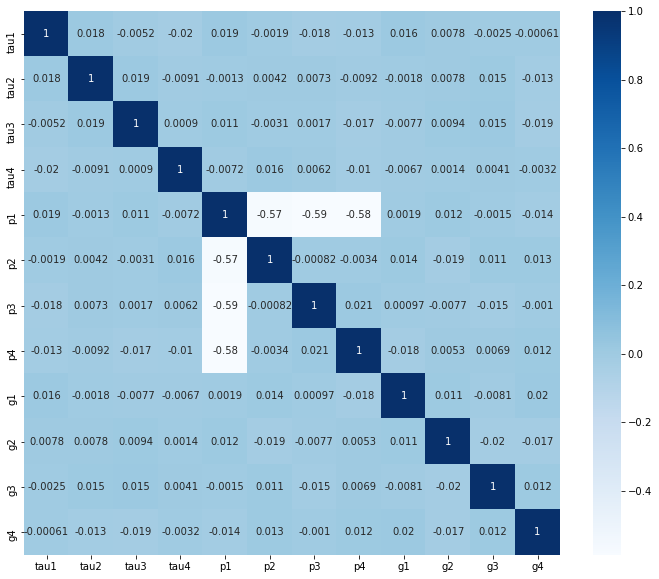

In [102]:
corr = train_samples.corr()

plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap=plt.cm.Blues)

In [103]:
train_labels.head()

,target
0,unstable
1,stable
2,unstable
3,unstable
4,unstable


## Data Preparation

In [104]:
# Prüfe auf N/A
train_samples.isna().sum()

tau1    0
tau2    0
tau3    0
tau4    0
p1      0
p2      0
p3      0
p4      0
g1      0
g2      0
g3      0
g4      0
dtype: int64

In [105]:
# entferne samples ohne Vorhersagekraft
train_samples.drop(columns=['p1'])

,tau1,tau2,tau3,tau4,p2,p3,p4,g1,g2,g3,g4
0,2.959060,3.079885,8.381025,9.780754,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034
1,9.304097,4.902524,3.047541,1.369357,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760
2,8.971707,8.848428,3.046479,1.214518,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853
3,0.716415,7.669600,4.486641,2.340563,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718
4,3.134112,7.608772,4.943759,9.857573,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923
...,...,...,...,...,...,...,...,...,...,...,...
7995,3.114442,4.781072,2.427918,7.989509,-0.918191,-0.652736,-1.102228,0.867950,0.888858,0.460587,0.965026
7996,5.754191,3.032743,5.084803,4.633624,-1.717030,-1.713212,-1.769009,0.157284,0.975921,0.511555,0.696591
7997,2.042954,8.514335,8.173809,5.466635,-1.639912,-0.662469,-1.481417,0.154129,0.944486,0.053225,0.499109
7998,2.930406,9.487627,2.376523,6.187797,-0.658054,-1.449106,-1.236256,0.601709,0.779642,0.813512,0.608385


In [106]:
feature_names = train_samples.columns

# standardize_data
scaler = StandardScaler()
train_samples = scaler.fit_transform(train_samples)

display(train_samples)

array([[-0.82825072, -0.79485973,  1.14812721, ...,  1.21449145,
         1.3198757 ,  1.57785437],
       [ 1.48053903, -0.13126006, -0.80134931, ...,  1.22482107,
         0.13767332,  0.93351917],
       [ 1.35959106,  1.30539358, -0.80173748, ...,  0.87615481,
         1.14543438, -1.52250346],
       ...,
       [-1.16159736,  1.18375437,  1.07238617, ...,  1.52375607,
        -1.71178545, -0.09965713],
       [-0.83867705,  1.53811757, -1.04661716, ...,  0.92333598,
         1.0511926 ,  0.29977985],
       [-0.67060649, -1.45205838, -0.83519386, ...,  0.1496986 ,
        -0.86628773, -0.58577037]])

In [107]:
#FIXME: Eigene Labels erstellen aus relativem Verhältnis? / Gesamtreaktionszeit

In [108]:
# Encodiere labels in 0 / 1 z. B. 0 = stable
label_encoder = LabelEncoder()
train_labels['target'] = label_encoder.fit_transform(train_labels['target'])
train_labels.head()

,target
0,1
1,0
2,1
3,1
4,1


In [109]:
# Aufteilen der Input-Daten in 70 % Trainings- und 30 % Testdaten
X_train, X_test, y_train, y_test = train_test_split(train_samples, train_labels, test_size=0.3, random_state=1) 

# display(X_train)
# display(y_train)

## Data Modeling

### Baseline Model - Decision Tree

In [110]:
# einfaches Prognosemodell
grid_sim_baseline = DecisionTreeClassifier(random_state=1,criterion="entropy")
grid_sim_baseline.fit(X_train, y_train)

y_pred_base = grid_sim_baseline.predict(X_test)
# apply transformation
# y_pred = label_encoder.inverse_transform(y_pred)
# print(y_pred)

### Advanced Model - Support Vector Machine

In [111]:
grid_sim_svm = SVC(C=1.2, kernel='rbf')
grid_sim_svm.fit(X_train,y_train)

y_pred_svm = grid_sim_svm.predict(X_test)

print(grid_sim_svm.get_params())

C:\Users\Markus\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
{'C': 1.2, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}


#### Tunen der Hypermeter

In [112]:
min_c = 0.1
step_size = 0.1
step_count = 15

C = min_c + np.arange(step_count)*step_size
print(C)

param_grid = {'C': C, 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf']}
grid_svm = GridSearchCV(SVC(),param_grid,refit=True,verbose=2)
grid_svm.fit(X_train,y_train)

grid_svm_optimized = grid_svm.best_estimator_

print(grid_svm.best_estimator_)

y_pred_svm_optimized = grid_svm.predict(X_test)


ages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[CV] ..... C=1.3000000000000003, gamma=0.01, kernel=rbf, total=   0.4s
[CV] C=1.3000000000000003, gamma=0.01, kernel=rbf ....................
C:\Users\Markus\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[CV] ..... C=1.3000000000000003, gamma=0.01, kernel=rbf, total=   0.4s
[CV] C=1.3000000000000003, gamma=0.01, kernel=rbf ....................
C:\Users\Markus\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwar

### Advanced Model - Random Forest Classifier

In [113]:
grid_sim_rf = RandomForestClassifier(n_estimators=200,)
grid_sim_rf.fit(X_train, y_train)
y_pred_rf = grid_sim_rf.predict(X_test)

print(grid_sim_rf.get_params())

<ipython-input-113-385d6b9fd416>:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  grid_sim_rf.fit(X_train, y_train)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


#### Tunen der Hyperparameter
- Wichtigster Parameter ist 'n_estimators', was der Anzahl der Bäume entspricht.
- Variiere 'n_estimators' von 10-250.
- Weitere Parameter werden nicht variiert, um den Rechenaufwand akzeptabel zu halten.

In [114]:
min_estimators = 10
max_estimators = 500

n_estimators = [int(x) for x in np.linspace(start = min_estimators, stop = max_estimators, num = 5)]

param_grid = {'n_estimators': n_estimators}

# Erzeuge Standard Random Forest und variiere dann Anzahl der Bäume.
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_rf.fit(X_train, y_train)

# Bester Versuch
grid_sim_rf_optimized = grid_rf.best_estimator_
print(grid_sim_rf_optimized.get_params())

y_pred_rf_optimized = grid_rf.predict(X_test)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    9.7s remaining:    8.5s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   16.0s finished
C:\Users\Markus\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Advanced Model - Voting Classifier (Random Forest + SVM)

In [115]:
grid_sim_voting = VotingClassifier(estimators=[('SVC', grid_svm_optimized), ('Random Forest', grid_sim_rf_optimized)], voting='hard')
grid_sim_voting.fit(X_train, y_train)
y_pred_voting = grid_sim_voting.predict(X_test)

C:\Users\Markus\anaconda3\lib\site-packages\sklearn\utils\validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


## Data Evaluation

### Evaluation of Baseline Model - Decision Tree

              precision    recall  f1-score   support

           0       0.81      0.78      0.79       886
           1       0.87      0.89      0.88      1514

    accuracy                           0.85      2400
   macro avg       0.84      0.84      0.84      2400
weighted avg       0.85      0.85      0.85      2400



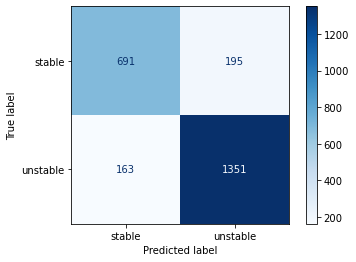

Matthews Corrcoeff 0.6776033774023483


In [116]:
print(classification_report(y_test, y_pred_base))
# FIXME: https://benalexkeen.com/decision-tree-classifier-in-python-using-scikit-learn/
plot_confusion_matrix(grid_sim_baseline, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)
plt.show()

# FIXME: Lese mehr darüber nach: https://towardsdatascience.com/the-best-classification-metric-youve-never-heard-of-the-matthews-correlation-coefficient-3bf50a2f3e9a
print("Matthews Corrcoeff", matthews_corrcoef(y_test, y_pred_base))

### Advanced Model - Support Vector Machine (getuned)

              precision    recall  f1-score   support

           0       0.95      0.93      0.94       886
           1       0.96      0.97      0.97      1514

    accuracy                           0.96      2400
   macro avg       0.95      0.95      0.95      2400
weighted avg       0.96      0.96      0.96      2400



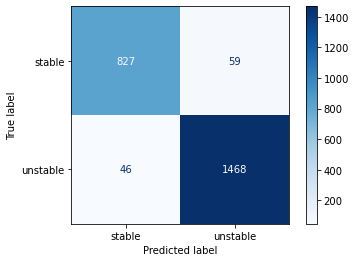

Matthews Corrcoeff 0.9058434868483985


In [117]:
print(classification_report(y_test, y_pred_svm_optimized))

plot_confusion_matrix(grid_svm_optimized, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)
plt.show()

print("Matthews Corrcoeff", matthews_corrcoef(y_test, y_pred_svm_optimized))

### Advanced Model - Random Forest (getuned)

              precision    recall  f1-score   support

           0       0.92      0.85      0.89       886
           1       0.92      0.96      0.94      1514

    accuracy                           0.92      2400
   macro avg       0.92      0.91      0.91      2400
weighted avg       0.92      0.92      0.92      2400



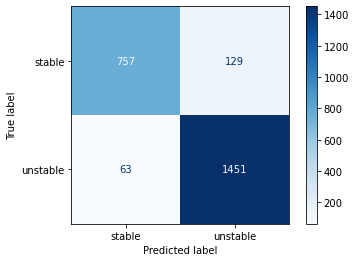

Matthews Corrcoeff 0.8234245303024987


In [118]:
print(classification_report(y_test, y_pred_rf_optimized))
plot_confusion_matrix(grid_sim_rf_optimized, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)
plt.show()

print("Matthews Corrcoeff", matthews_corrcoef(y_test, y_pred_rf))

### Voting / Stacking (hypertuned)

              precision    recall  f1-score   support

           0       0.90      0.96      0.93       886
           1       0.98      0.94      0.96      1514

    accuracy                           0.95      2400
   macro avg       0.94      0.95      0.94      2400
weighted avg       0.95      0.95      0.95      2400



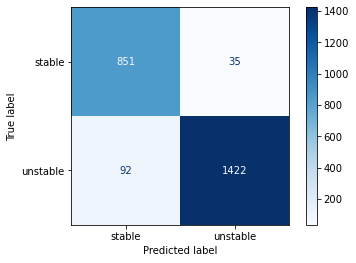

Matthews Corrcoeff 0.8890098772852834


In [119]:
print(classification_report(y_test, y_pred_voting))
plot_confusion_matrix(grid_sim_voting, X_test, y_test, display_labels=label_encoder.classes_, cmap=plt.cm.Blues)
plt.show()

print("Matthews Corrcoeff", matthews_corrcoef(y_test, y_pred_voting))

In [120]:
# dot_data = StringIO()

# export_graphviz(grid_sim_baseline, out_file=dot_data,  filled=True, rounded=True,special_characters=True, feature_names=feature_names, class_names=label_encoder.classes_)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('grid.png')
# Image(graph.create_png())


In [121]:
# entferne samples ohne Vorhersagekraft
test_samples.drop(columns=['p1'])

# Standardisiere Daten
test_samples = scaler.fit_transform(test_samples)

prediction_test = grid_sim_voting.predict(test_samples)

prediction = pd.DataFrame(prediction_test, columns=['target'])
prediction['target'] = label_encoder.inverse_transform(prediction['target'])
prediction.to_csv(filepath_prediction_labels, sep='|', index=False)

prediction.head()

,target
0,unstable
1,stable
2,unstable
3,stable
4,unstable
